In [1]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=2f0b978e50a845aa2e9d7b56cb99bc780f06251fefbd79d56828fdecb3fdef0c
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from pyDOE import lhs

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc

np.random.seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
 # Neural Network
class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"] #lb.to(device)
        self.UpperBounds = model_parameters["UpperBounds"] #ub.to(device)
        self.ThermalDiffusivity = model_parameters["ThermalDiffusivity"] #alpha
        self.InputDimensions = model_parameters["InputDimensions"] #2
        self.OutputDimensions = model_parameters["OutputDimensions"] #1
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"] #10
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"] #4
        self.ActivationFunction = model_parameters["ActivationFunction"] #nn.Tanh()
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)


    def forward(self, x):
        lb = self.LowerBounds
        ub = self.UpperBounds
        x = 2*(x - lb)/(ub - lb) - 1
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def internalEnergyBalanceResidue(self, X, T):

        alpha = self.ThermalDiffusivity

        # Compute the derivatives of the output w.r.t. the inputs (space and time) using AD mechanism:
        diff_T = torch.autograd.grad(T, X, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        Tx, Tt = diff_T[:, 0:1], diff_T[:, 1:2]

        # Compute the second derivative of the output w.r.t. the inputs (only space) using AD mechanism:
        Txx = torch.autograd.grad(Tx, X, create_graph=True, grad_outputs=torch.ones_like(T))[0][:, 0:1]

        residue = Tt - alpha*Txx
        return residue

## Problem data

In [4]:
# Properties of pure solid aluminium
k = 210.0 # W/(m K)
C = 900.0 # J/(kg K)
rho = 2700.0 #kg/m^3
alpha_true = k/(rho*C)

# Boundaries of space and time domains
ti, tf = 0, 1000.0 # s
xi, xf = 0, 1.0 # m

# Non-dimensionalization
#tf *= alpha
#alpha = 1

lb = torch.tensor([xi, ti])
ub = torch.tensor([xf, tf])

# Initial and boundary temperatures
T_ref = 100 #100.
bc_value = bc_value_l = bc_value_r = 300.0/T_ref # K
k1 = np.pi/xf
T_ampl = 100.0/T_ref # K
T0 = lambda x: T_ampl*torch.sin(k1*x) + bc_value # K

## Exact solution

In [7]:
# Exact solution
T_exact = lambda x, t: T_ampl*np.sin(k1*x)*np.exp(-k1**2*alpha_true*t) + bc_value

# Grid for evaluation the exact solution
x_test = np.linspace(xi, xf, 1000)
t_test = np.linspace(ti, tf, 1000)
ms_x, ms_t = np.meshgrid(x_test, t_test)
x_test = np.ravel(ms_x).reshape(-1,1)
t_test = np.ravel(ms_t).reshape(-1,1)

T_ex_grid = T_ref*T_exact(x_test, t_test).reshape(ms_x.shape)

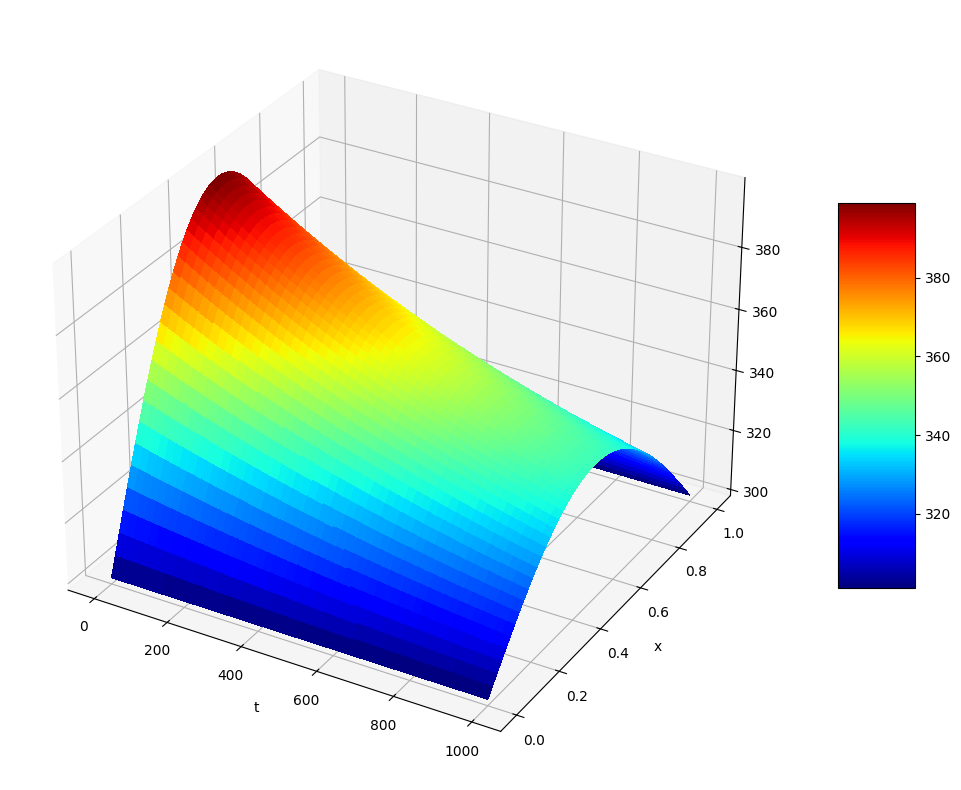

In [8]:
# Plot the exact temperature distribution
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection = '3d')
#ax.view_init(elev=20, azim=-90)
surf1 = ax.plot_surface(ms_t, ms_x, T_ex_grid, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf1, shrink=0.5, aspect=5)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

## Datasets (collocation points and labelled data points)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx, :]
        target = self.y[idx, :]
        return features, target

In [10]:
# Generate equispaced tensors for both space and time domains to pick from
x_tensor = torch.linspace(xi, xf, 10000, device=device)
t_tensor = torch.linspace(ti, tf, 10000, device=device)

# Number of collocation points
N_dom = 1000 # Number of collocation points for evaluating the residuals
N_bc = 300 # Number of collocation points for computing the boundary conditions
N_ic = 500 # Number of collocation points for computing the initial condition
N_data = 1000 # Number of labelled data points

# Train, validation and testing sets
tags = ["Domain", "BoundaryConditions", "InitialCondition"]
isData = True # Flag to indicate whether the analysis would use labelled data or not

# Initialize list of dataset objects
ds = []

In [11]:
## Collocation points for evaluating the residual of the governing PDE

# Generate collocation points within the domain using Latin Hypercube Sampling (LHS) strategy
X_dom = (lb + (ub - lb)*lhs(2, N_dom)).to(torch.float32).to(device)
y_dom = torch.zeros((N_dom, 1), device=device)

# Generate random collocation points for the left boundary to add to the domain dataset
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_l = t_tensor[idx_bc].view(-1, 1)
x_bc_l = xi*torch.ones((N_bc, 1), device=device)
X_bc_l = torch.cat([x_bc_l, t_bc_l], axis=1)
y_bc_l = torch.zeros((N_bc, 1), device=device)

# Generate random collocation points for the right boundary to add to the domain dataset
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_r = t_tensor[idx_bc].view(-1, 1)
x_bc_r = xf*torch.ones((N_bc, 1), device=device)
X_bc_r = torch.cat([x_bc_r, t_bc_r], axis=1)
y_bc_r = torch.zeros((N_bc, 1), device=device)

# Generate collocation points for the initial condition to add to the domain dataset
idx_ic = np.random.choice(x_tensor.size()[0], N_ic, replace=False)
x_ic = x_tensor[idx_ic].view(-1, 1)
t_ic = ti*torch.ones((N_ic, 1), device=device)
X_ic = torch.cat([x_ic, t_ic], axis=1)
y_ic = torch.zeros((N_ic, 1), device=device)

# Concatenate X_dom dataset
X_dom = torch.cat([X_dom, X_bc_l, X_bc_r, X_ic], axis=0)
y_dom = torch.cat([y_dom, y_bc_l, y_bc_r, y_ic], axis=0)
ds.append(CustomDataset(X_dom, y_dom))

In [12]:
## Collocation points for evaluating the boundary and initial conditions

# Generate random collocation points for the left boundary
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_l = t_tensor[idx_bc].view(-1, 1)
x_bc_l = xi*torch.ones((N_bc, 1), device=device)
X_bc_l = torch.cat([x_bc_l, t_bc_l], axis=1)
y_bc_l = torch.full((N_bc, 1), bc_value_l)

# Generate random collocation points for the right boundary
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_r = t_tensor[idx_bc].view(-1, 1)
x_bc_r = xf*torch.ones((N_bc, 1), device=device)
X_bc_r = torch.cat([x_bc_r, t_bc_r], axis=1)
y_bc_r = torch.full((N_bc, 1), bc_value_r)

# Concatenate the collocation points of both boundaries
X_bc = torch.cat([X_bc_l, X_bc_r], axis=0)
y_bc = torch.cat([y_bc_l, y_bc_r], axis=0)
ds.append(CustomDataset(X_bc, y_bc))

# Generate collocation points for the initial condition
idx_ic = np.random.choice(x_tensor.size()[0], N_ic, replace=False)
x_ic = x_tensor[idx_ic].view(-1, 1)
t_ic = ti*torch.ones((N_ic, 1), device=device)
X_ic = torch.cat([x_ic, t_ic], axis=1)
y_ic = T0(x_ic)
ds.append(CustomDataset(X_ic, y_ic))

In [13]:
# Generate syntetic temperature labelled data
if isData:
    tags.append("LabelledData")
    omega = 0.01
    sensor_loc = [0.25, 0.5, 0.9]
    x_data, t_data = [], []
    for loc in sensor_loc:
        idx_data = np.random.choice(x_tensor.size()[0], N_data, replace=False)
        x_data.append(torch.full((N_data, 1), loc, device=device))
        t_data.append(t_tensor[idx_data].view(-1, 1))

    X_data = torch.cat([torch.cat(x_data, axis=0), torch.cat(t_data, axis=0)], axis=1)
    exact_temp_data = T_exact(X_data[:, 0].data.cpu().numpy(), X_data[:, 1].data.cpu().numpy())
    noisy_temp_data = exact_temp_data.reshape(-1, 1) + omega*np.max(exact_temp_data)*np.random.normal(size=(len(sensor_loc)*N_data, 1))
    y_data = torch.from_numpy(noisy_temp_data).to(torch.float32).to(device)
    ds.append(CustomDataset(X_data, y_data))



In [14]:
# Dictionary of dataset objects
datasets = dict(zip(tags, ds))

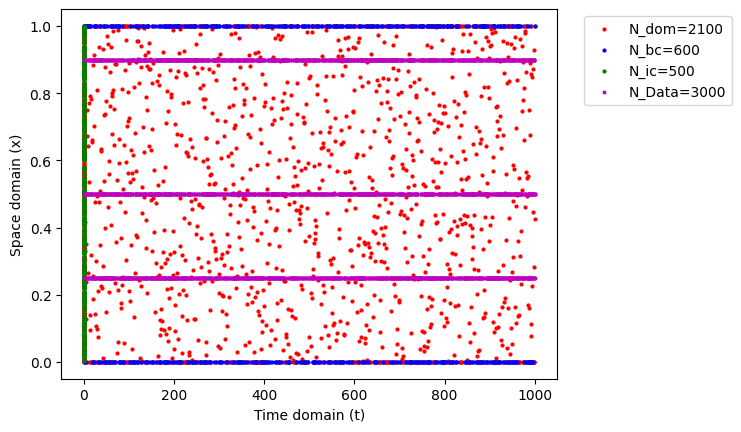

In [15]:
# Plot the locations of the collocation points in the space-time domain
X_dom_train = (datasets["Domain"].X).data.cpu().numpy()
X_bc_train = (datasets["BoundaryConditions"].X).data.cpu().numpy()
X_ic_train = (datasets["InitialCondition"].X).data.cpu().numpy()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_dom_train[:, 1:2], X_dom_train[0:, 0:1], s=4, c='r', label=f'N_dom={len(X_dom_train)}')
ax.scatter(X_bc_train[:, 1:2], X_bc_train[:, 0:1], s=4, c='b', label=f'N_bc={len(X_bc_train)}')
ax.scatter(X_ic_train[:, 1:2], X_ic_train[:, 0:1], s=4, c='g', label=f'N_ic={len(X_ic_train)}')
if isData:
    X_data_train = (datasets["LabelledData"].X).data.cpu().numpy()
    y_data_train = (datasets["LabelledData"].y).data.cpu().numpy()
    ax.scatter(X_data_train[:, 1:2], X_data_train[:, 0:1], s=4, c='m', label=f'N_Data={len(X_data_train)}', marker='x')
ax.legend()
plt.xlabel('Time domain (t)')
plt.ylabel('Space domain (x)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

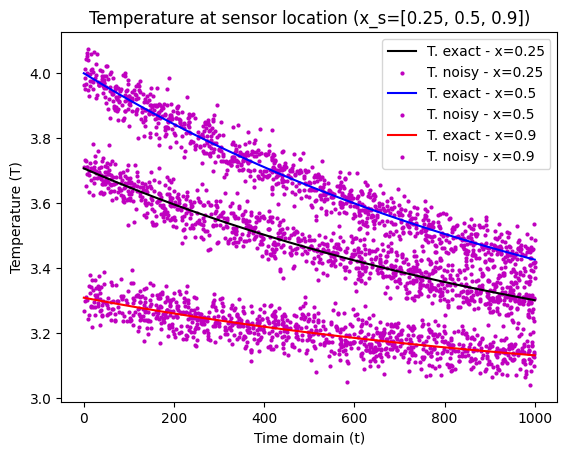

In [16]:
if isData:
    colors = ['k', 'b', 'r', 'g']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i, sensor in enumerate(sensor_loc):
        t_data_loc = np.linspace(ti, tf, N_data).reshape(-1, 1)
        x_data_loc = np.full((N_data, 1), sensor)
        T_ex = T_exact(x_data_loc, t_data_loc)
        ax.plot(t_data_loc, T_ex, c=colors[i], label=f'T. exact - x={sensor}')
        ax.scatter(X_data_train[N_data*i:N_data*(i+1), 1:2], y_data_train[N_data*i:N_data*(i+1)], s=4, c='m', label=f'T. noisy - x={sensor}')

    ax.legend()
    plt.xlabel('Time domain (t)')
    plt.ylabel('Temperature (T)')
    plt.title(f'Temperature at sensor location (x_s={sensor_loc})')
    plt.show()

## Main execution - Implementation 1

In [20]:
# Input dictionary for model instance
alpha_inv_input = nn.Parameter(torch.tensor(1.0)) #Make alpha a trainable parameter
tanh = nn.Tanh()
alpha_fun = lambda x: x*tanh(1e3*x) #torch.exp(x) #x*tanh(1e3*x)
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "ThermalDiffusivity": alpha_fun(alpha_inv_input),
    "InputDimensions": 2,
    "OutputDimensions": 1,
    "NumberOfNeurons": 30,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.Tanh()
}
print('alpha_true: ', alpha_true,'alpha_inv_input: ', alpha_inv_input.item(), 'alpha_inv: ', alpha_fun(alpha_inv_input).item())

alpha_true:  8.641975308641975e-05 alpha_inv_input:  1.0 alpha_inv:  1.0


In [21]:
def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            torch.nn.init.uniform_(m.bias, 0, 1)

    model.apply(init_weights)

In [22]:
# Model construction
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)
init_xavier(model)

In [23]:
# Fitting stage
t0 = datetime.now()
data_time_now = datetime.now().strftime("%d%m%Y_%H%M%S")

epochs = 20000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam([
    {'params': model.parameters(), 'lr': 1e-3}, {'params': alpha_inv_input, 'lr': 0.01}],
                             weight_decay=1e-3)
    #list(model.parameters()) + [alpha_inv_input],
    #lr=0.001, weight_decay=1e-3)
loss_train = []
loss_train_dom = []
loss_train_bc = []
loss_train_ic = []
loss_train_data = []
alpha_values = []
train_keys = ['Overall', 'Domain', 'BC', 'IC', 'Data', 'alpha']
for epoch in range(epochs):
    loss_list = []
    optimizer.zero_grad()
    for tag in tags:
        X = (datasets[tag].X).to(device)
        #X[:, 1:2].data = X[:, 1:2].data*alpha_inv_fun(alpha_inv_input)
        y = (datasets[tag].y).to(device)
        if tag=='Domain':
            X.requires_grad = True
            T = model(X)
            y_hat = model.internalEnergyBalanceResidue(X, T)
            loss = loss_fn(y_hat, y)
            loss_list.append(loss)

        else:
            T = model(X)
            loss = loss_fn(T, y)
            loss_list.append(loss)

    loss = sum(loss_list)
    if loss<1e-4:
        print('Overall loss dropped below tolerance value of 1e-4. Training stopped.')
        break
    loss.backward()
    optimizer.step()

    loss_list.insert(0, loss)
    loss_train.append(loss_list[0].item())
    loss_train_dom.append(loss_list[1].item())
    loss_train_bc.append(loss_list[2].item())
    loss_train_ic.append(loss_list[3].item())
    if isData:
        loss_train_data.append(loss_list[4].item())

    alpha_values.append(alpha_inv_input.item())
    loss_list.append(alpha_fun(alpha_inv_input).item()) #loss_list.append(alpha_inv_fun(alpha_inv_input).item())

    model.ThermalDiffusivity = alpha_fun(alpha_inv_input) #alpha_inv_fun(alpha_inv_input).item()

    if epoch % 100 == 0:
        log_dict = dict(zip(train_keys, loss_list))
        aux = "".join(f"{key}: {value:.5e}, " for key, value in log_dict.items())
        optimizer_str = type(optimizer).__name__
        print(f"##TRAIN## {optimizer_str} - Epoch: {epoch}, " + aux)

elapsed_time_train = datetime.now() - t0
print("\nTraining Time: ", elapsed_time_train.seconds, "[s]")

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


##TRAIN## Adam - Epoch: 0, Overall: 2.52548e+01, Domain: 1.03592e-02, BC: 6.36251e+00, IC: 1.00276e+01, Data: 8.85437e+00, alpha: 9.90000e-01, 
##TRAIN## Adam - Epoch: 100, Overall: 2.81006e-01, Domain: 1.44986e-03, BC: 1.06340e-01, IC: 1.20280e-01, Data: 5.29369e-02, alpha: 1.79107e-01, 
##TRAIN## Adam - Epoch: 200, Overall: 1.96603e-01, Domain: 1.44267e-07, BC: 7.25927e-02, IC: 8.43937e-02, Data: 3.96168e-02, alpha: 2.93770e-05, 
##TRAIN## Adam - Epoch: 300, Overall: 1.94329e-02, Domain: 7.70959e-08, BC: 6.09900e-03, IC: 7.32903e-03, Data: 6.00477e-03, alpha: 2.31791e-05, 
##TRAIN## Adam - Epoch: 400, Overall: 9.86384e-03, Domain: 6.61224e-08, BC: 2.29349e-03, IC: 2.79411e-03, Data: 4.77618e-03, alpha: 3.22449e-05, 
##TRAIN## Adam - Epoch: 500, Overall: 5.19954e-03, Domain: 6.54295e-08, BC: 8.91656e-04, IC: 1.18596e-03, Data: 3.12186e-03, alpha: 4.29184e-05, 
##TRAIN## Adam - Epoch: 600, Overall: 3.60023e-03, Domain: 6.15918e-08, BC: 4.01645e-04, IC: 6.03009e-04, Data: 2.59552e-03, a

KeyboardInterrupt: 

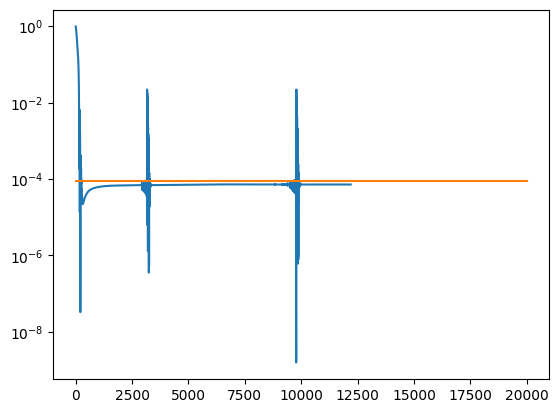

In [24]:
plt.semilogy(alpha_fun(torch.tensor(alpha_values)).cpu().detach().numpy())
plt.plot([0, 20000], [alpha_true, alpha_true])
plt.show()

## Loss functions

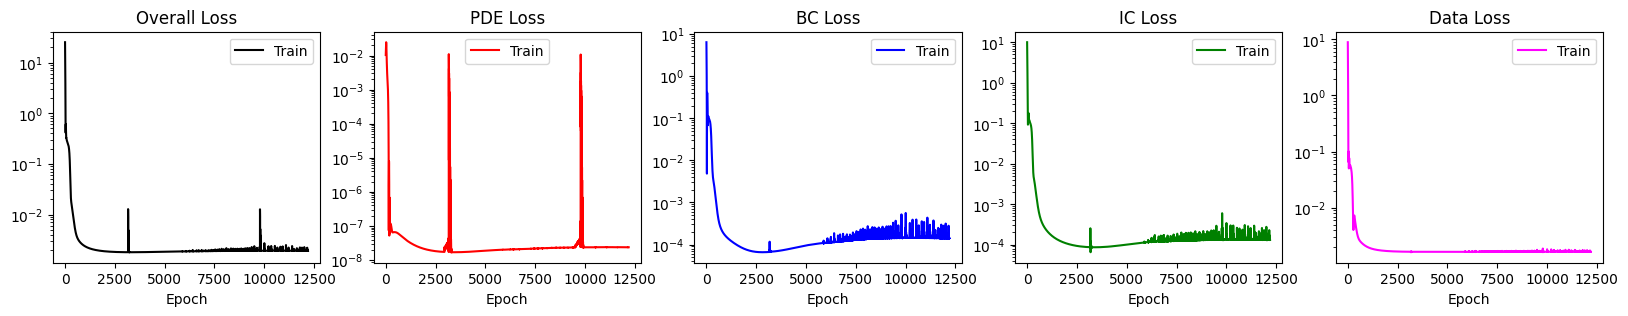

In [25]:
# Evolution of the loss function
loss_train_list = [loss_train, loss_train_dom, loss_train_bc, loss_train_ic]
colors = ['black', 'red', 'blue', 'green']
titles = ['Overall Loss', 'PDE Loss', 'BC Loss', 'IC Loss']
if isData:
    loss_train_list.append(loss_train_data)
    colors.append('magenta')
    titles.append('Data Loss')

fig, ax = plt.subplots(1, len(loss_train_list), figsize=(20, 3))
for i in range(len(loss_train_list)):
    epochs_train = np.arange(0, len(loss_train_list[i]))
    ax[i].semilogy(epochs_train, loss_train_list[i], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()

## Prediction

In [26]:
# Definition of tensors from the testing points for evaluating the trained PINN
pt_x = torch.from_numpy(x_test).float()
pt_t = torch.from_numpy(t_test).float()
ms_Tex = T_ref*T_exact(x_test, t_test).reshape(ms_x.shape)

In [27]:
# Predicted solution
X_pred = torch.cat([pt_x, pt_t], axis=1).to(device)
Tpred = model(X_pred).data.cpu().numpy()
ms_Tpred = T_ref*Tpred.reshape(ms_x.shape)

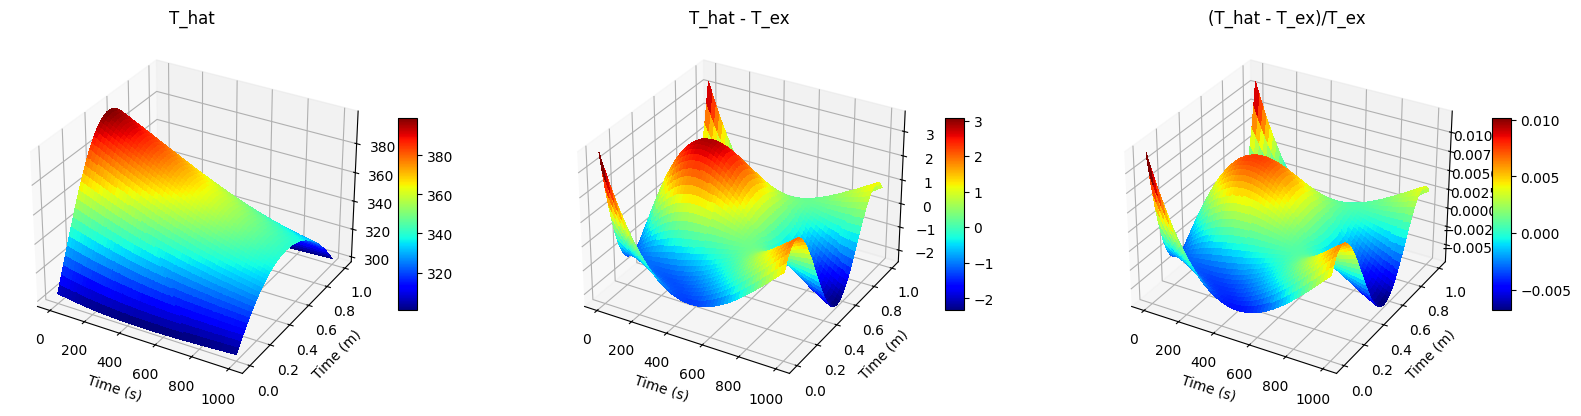

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
ax = axs[0]
surf = ax.plot_surface(ms_t, ms_x, ms_Tpred, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('T_hat')
ax = axs[1]
surf = ax.plot_surface(ms_t, ms_x, ms_Tpred-ms_Tex, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('T_hat - T_ex')
ax = axs[2]
surf = ax.plot_surface(ms_t, ms_x, (ms_Tpred-ms_Tex)/ms_Tex, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('(T_hat - T_ex)/T_ex')
plt.show()

## Main execution - Implementation 2

In [17]:
# Input dictionary for model instance
alpha_inv_input = nn.Parameter(torch.tensor(1.0)) #Make alpha a trainable parameter
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "ThermalDiffusivity": alpha_inv_input,
    "InputDimensions": 2,
    "OutputDimensions": 1,
    "NumberOfNeurons": 10,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.Tanh()
}
print('alpha_inv_input: ', alpha_inv_input.item())

alpha_inv_input:  1.0


In [18]:
def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            torch.nn.init.uniform_(m.bias, 0, 1)

    model.apply(init_weights)

In [19]:
# Model construction
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)
init_xavier(model)

In [276]:
# Fitting stage
t0 = datetime.now()
data_time_now = datetime.now().strftime("%d%m%Y_%H%M%S")

epochs = 20000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(
    list(model.parameters()) + [alpha_inv_input],
    lr=0.0001)
loss_train = []
loss_train_dom = []
loss_train_bc = []
loss_train_ic = []
loss_train_data = []
alpha_values = []
train_keys = ['Overall', 'Domain', 'BC', 'IC', 'Data', 'alpha']
for epoch in range(epochs):
    loss_list = []
    for tag in tags:
        X = (datasets[tag].X).detach().to(device)
        #X[:, 1:2] = X[:, 1:2]*((alpha_inv_input.data).item())
        y = (datasets[tag].y).to(device)
        if tag=='Domain':
            X.requires_grad = True
            T = model(X)
            y_hat = model.internalEnergyBalanceResidue(X, T)
            loss = loss_fn(y_hat, y)
            loss_list.append(loss)

        else:
            T = model(X)
            loss = loss_fn(T, y)
            loss_list.append(loss)

        del X, y

    optimizer.zero_grad()
    loss = sum(loss_list)
    loss.backward()
    optimizer.step()

    # Clamp alpha_input to keep them positive ###REVISAR IMPLEMENTACION!!!!!
    with torch.no_grad():
        alpha_inv_input.clamp_(min=1e-8)

    loss_list.insert(0, loss)
    loss_train.append(loss_list[0].item())
    loss_train_dom.append(loss_list[1].item())
    loss_train_bc.append(loss_list[2].item())
    loss_train_ic.append(loss_list[3].item())
    if isData:
        loss_train_data.append(loss_list[4].item())

    loss_list.append(alpha_inv_input.item())
    alpha_values.append(alpha_inv_input.item())

    model.ThermalDiffusivity = alpha_inv_input

    if epoch % 100 == 0:
        log_dict = dict(zip(train_keys, loss_list))
        aux = "".join(f"{key}: {value:.5e}, " for key, value in log_dict.items())
        optimizer_str = type(optimizer).__name__
        print(f"##TRAIN## {optimizer_str} - Epoch: {epoch}, " + aux)

elapsed_time_train = datetime.now() - t0
print("\nTraining Time: ", elapsed_time_train.seconds, "[s]")

##TRAIN## Adam - Epoch: 0, Overall: 1.02917e-01, Domain: 7.19746e-02, BC: 1.62977e-02, IC: 8.19489e-03, Data: 6.45003e-03, alpha: 9.99800e-01, 
##TRAIN## Adam - Epoch: 100, Overall: 2.32472e-02, Domain: 1.33055e-02, BC: 6.35995e-03, IC: 1.68750e-03, Data: 1.89419e-03, alpha: 9.86381e-01, 
##TRAIN## Adam - Epoch: 200, Overall: 9.74234e-03, Domain: 4.05444e-03, BC: 3.16777e-03, IC: 1.22063e-03, Data: 1.29951e-03, alpha: 9.81121e-01, 
##TRAIN## Adam - Epoch: 300, Overall: 5.31010e-03, Domain: 1.46647e-03, BC: 1.79660e-03, IC: 1.04188e-03, Data: 1.00516e-03, alpha: 9.78744e-01, 
##TRAIN## Adam - Epoch: 400, Overall: 3.62814e-03, Domain: 5.93405e-04, BC: 1.18413e-03, IC: 9.79267e-04, Data: 8.71332e-04, alpha: 9.77617e-01, 
##TRAIN## Adam - Epoch: 500, Overall: 2.99914e-03, Domain: 2.74000e-04, BC: 9.33371e-04, IC: 9.64889e-04, Data: 8.26883e-04, alpha: 9.77039e-01, 
##TRAIN## Adam - Epoch: 600, Overall: 2.75993e-03, Domain: 1.46521e-04, BC: 8.37432e-04, IC: 9.61989e-04, Data: 8.13986e-04, a

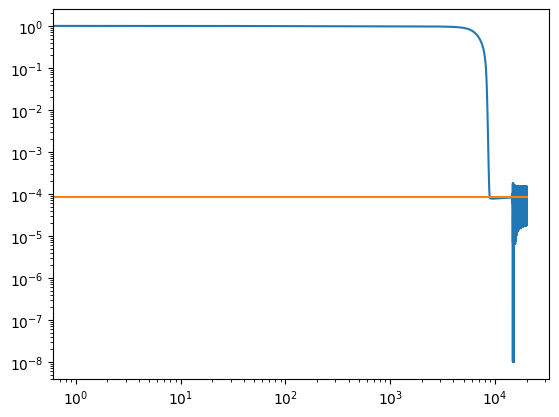

In [283]:
plt.loglog(alpha_values)
plt.plot([0, 20000], [alpha_true, alpha_true])
plt.show()

## Loss functions

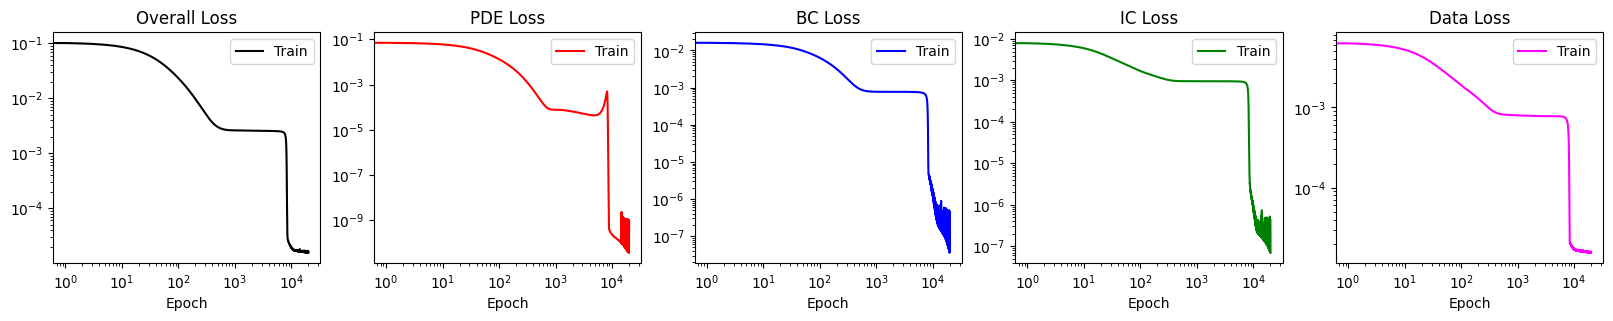

In [284]:
# Evolution of the loss function
loss_train_list = [loss_train, loss_train_dom, loss_train_bc, loss_train_ic]
colors = ['black', 'red', 'blue', 'green']
titles = ['Overall Loss', 'PDE Loss', 'BC Loss', 'IC Loss']
if isData:
    loss_train_list.append(loss_train_data)
    colors.append('magenta')
    titles.append('Data Loss')

fig, ax = plt.subplots(1, len(loss_train_list), figsize=(20, 3))
for i in range(len(loss_train_list)):
    epochs_train = np.arange(0, len(loss_train_list[i]))
    ax[i].loglog(epochs_train, loss_train_list[i], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()

## Prediction

In [285]:
# Definition of tensors from the testing points for evaluating the trained PINN
pt_x = torch.from_numpy(x_test).float()
pt_t = torch.from_numpy(t_test).float()
ms_Tex = T_ref*T_exact(x_test, t_test).reshape(ms_x.shape)

In [286]:
# Predicted solution
X_pred = torch.cat([pt_x, pt_t], axis=1).to(device)
Tpred = model(X_pred).data.cpu().numpy()
ms_Tpred = T_ref*Tpred.reshape(ms_x.shape)

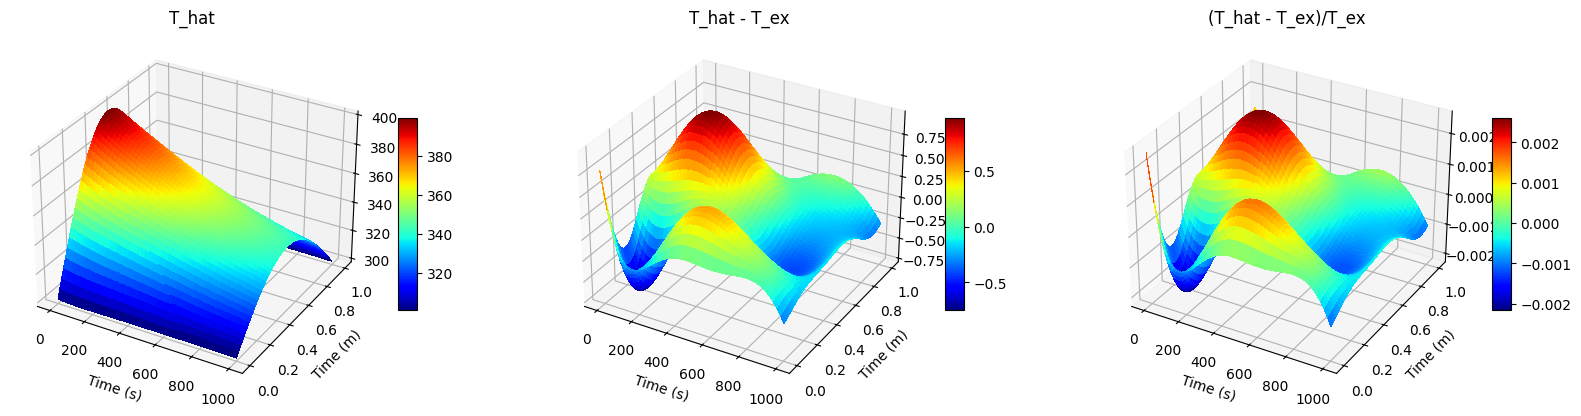

In [287]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
ax = axs[0]
surf = ax.plot_surface(ms_t, ms_x, ms_Tpred, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('T_hat')
ax = axs[1]
surf = ax.plot_surface(ms_t, ms_x, ms_Tpred-ms_Tex, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('T_hat - T_ex')
ax = axs[2]
surf = ax.plot_surface(ms_t, ms_x, (ms_Tpred-ms_Tex)/ms_Tex, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('(T_hat - T_ex)/T_ex')
plt.show()